In [1]:
import numpy as np
import matplotlib.pylab as plt
import pickle
import json
import new_files
import pandas as pd
import nibabel as nb
from os import sep
from copy import deepcopy
from scipy.interpolate import interp1d
from matplotlib import colors
import elephant
import neo
import quantities as pq
import matplotlib.pylab as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import colors
import trimesh
import open3d as o3d
from ffntr import fooofinator
from tools import compute_rel_power, get_crossover, detect_crossing_points, data_to_rgb
from sklearn.preprocessing import minmax_scale

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [53]:
def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None, return_details=False):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    elif vmin_vmax == "norm":
        divnorm = colors.Normalize()
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd[::-1,:], norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    ax.set_yticks(np.linspace(0,1, num=info["layers"]))
    ax.set_yticklabels(np.arange(1,12))
    layers_params = []
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
        ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
        ax.annotate(layer_labels[l_ix],[times[0]+0.06, th-0.01], size=15, ha='left')
        layers_params.append([th, layer_labels[l_ix]])
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()
    if return_details:
        return layers_params, csd_imshow


def plot_spaced_signal(signal, times, ax):
    v_contacts = signal.shape[0]
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=v_contacts))[:,:3]
    max_amp = np.abs(signal).max()
    max_amp = max_amp + max_amp*0.05
    spacing = np.linspace(0, max_amp * v_contacts, num=v_contacts)
    vis_signal = signal + spacing.reshape(-1,1)
    for ix, vs in enumerate(vis_signal):
        ax.plot(times, vs, lw=1, c=cm_l[ix])
    ax.set_yticks(spacing)
    ax.set_yticklabels(np.arange(1,v_contacts+1)[::-1])
    ax.set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)


def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None, return_details=False):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    elif vmin_vmax == "norm":
        divnorm = colors.Normalize()
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    ax.set_yticks(np.linspace(0,1, num=info["layers"]))
    ax.set_yticklabels(np.arange(1,12))
    layers_params = []
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
        ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
        ax.annotate(layer_labels[l_ix],[times[0]+0.06, th-0.01], size=15, ha='left')
        layers_params.append([th, layer_labels[l_ix]])
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()
    if return_details:
        return layers_params, csd_imshow

    
def custom_draw_geometry(mesh, filename="render.png", visible=True, wh=[960, 960], save=True):
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=wh[0], height=wh[1], visible=visible)
    if isinstance(mesh, list):
        for i in mesh:
            vis.add_geometry(i)
    else:
        vis.add_geometry(mesh)
    vis.get_render_option().mesh_show_back_face=True
    vis.get_render_option().light_on=True
    vis.run()
    if save:
        vis.capture_screen_image(filename, do_render=True)
    vis.destroy_window()


def csd_calc(signal, thickness, sfreq):
    """
    signal - contact x time
    thickness - overall in mm
    sampling rate - in Hz
    """
    sig = neo.core.AnalogSignal(
        signal.T, units="T", sampling_rate=sfreq*pq.Hz
    )
    th = pq.Quantity(np.linspace(0, thickness, num=11).reshape(-1,1)) * pq.mm
    csd_est = elephant.current_source_density.estimate_csd(
        sig, th,
        method = "StandardCSD"
    )
    return csd_est.as_array().T


def csd_smooth(csd, layers=11, kind="cubic"):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = interp1d(x, csd[:, t], kind=kind)
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed


def plot_spaced_signal(signal, times, ax):
    v_contacts = signal.shape[0]
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=v_contacts))[:,:3]
    max_amp = np.abs(signal).max()
    max_amp = max_amp + max_amp*0.05
    spacing = np.linspace(0, max_amp * v_contacts, num=v_contacts)
    vis_signal = signal + spacing.reshape(-1,1)
    for ix, vs in enumerate(vis_signal):
        ax.plot(times, vs, lw=1, c=cm_l[ix])
    ax.set_yticks(spacing)
    ax.set_yticklabels(np.arange(1,v_contacts+1)[::-1])
    ax.set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)

In [3]:
epoch_types = {
    "visual": [np.linspace(-0.2, 0.8, num=601), [0.0, 0.2], -0.01],
    "motor": [np.linspace(-0.5, 0.5, num=601), [-0.2, 0.2], -0.2]
}

crop_info = {
    "visual": (-0.2, 0.8),
    "motor": (-0.5, 0.5)
}

flims = [0.1,125] # freq limits for psd

In [4]:
dir_search = new_files.Files()
img_path = "/scratch/poster_visualisations"
all_results = dir_search.get_files(img_path,"*.pickle", strings=["raw_preproc"])
all_results.sort()

In [57]:
pickle_file = all_results[2]
print(pickle_file)
epoch_type = [i for i in epoch_types.keys() if i in pickle_file.split(sep)[-1]][0]
with (open(pickle_file, "rb")) as file:
    data = pickle.load(file)

with open(data["json"]) as pipeline_file:
    info = json.load(pipeline_file)

metric = data["log_variance"]
atlas_labels = data["atlas_labels"]
clusters = data["clusters"]
results_vx_dict = data["vertex_mean_signal_psd"]
cortical_thickness = np.load(info["cortical_thickness_path"])
times = epoch_types[epoch_type][0]

max_vx = np.hstack(clusters)[np.argmax(metric[np.hstack(clusters)])]
cluster = [i for i in clusters if max_vx in i][0]
max_vx_ix = np.where(cluster == max_vx)[0]
signal = results_vx_dict[(max_vx, "signal")]
CSD_res = csd_calc(signal, cortical_thickness[max_vx], 600.0);
CSD_res[0] = np.zeros(CSD_res[0].shape)
CSD_res[-1] = np.zeros(CSD_res[0].shape)
csd_csd = deepcopy(CSD_res)
CSD_res = csd_smooth(CSD_res)
baseline_lim = epoch_types[epoch_type][2]
baseline = np.mean(CSD_res[:, np.where(epoch_types[epoch_type][0] < baseline_lim)], axis=2)
CSD_res = CSD_res - baseline
CSD_res = (CSD_res - CSD_res.mean()) / CSD_res.std()
freqs = results_vx_dict["freqs"]
layer_power = results_vx_dict[(max_vx, "mean_psd")]
layer_power = layer_power - np.mean(layer_power, axis=1).reshape(-1, 1)
relative_power = compute_rel_power(layer_power, freqs)
smooth_power = csd_smooth(relative_power)
try:
    crossover = get_crossover(freqs, smooth_power, smooth_power)
except:
    crossover = 0

/scratch/poster_visualisations/raw_preproc_autoreject-sub-001-ses-01-002-motor-epo.pickle
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


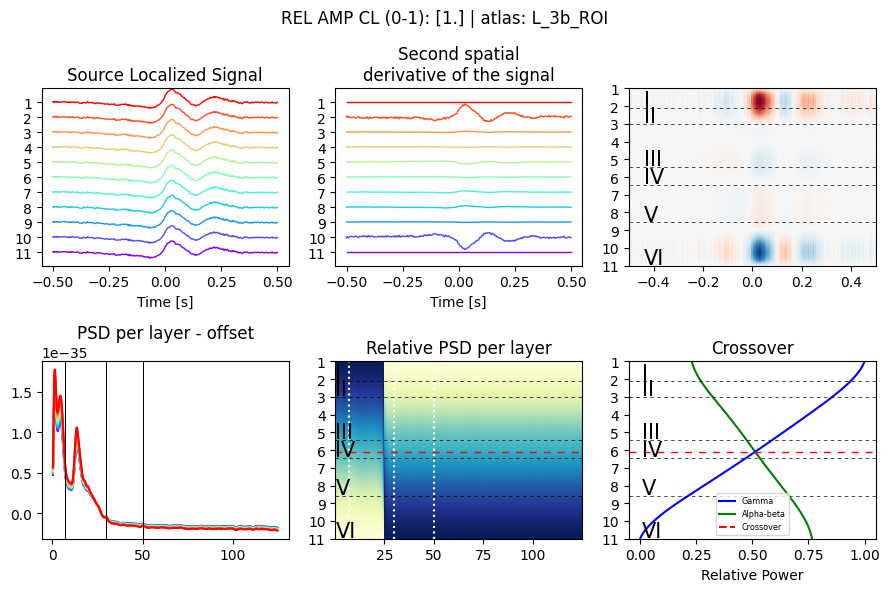

In [58]:
def plot_new_basic_results(
    info, vertex_no, cl_vx, signal, times, CSD_res, cluster, 
    epoch_types, epoch_type, freqs, layer_power, crossover,
    relative_power, smooth_power, csd_csd):
    
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=info["layers"]))[:,:3]

    f, ax = plt.subplots(2,3, figsize=(9,6))

    plot_spaced_signal(signal, times, ax=ax[0,0])
    plot_spaced_signal(csd_csd, times, ax=ax[0,1])
    cst_det = plot_csd(
        CSD_res, cluster, info["big_brain_layers_path"], 
        epoch_types[epoch_type][0], ax=ax[0,2], cb=False,
        return_details=True
    )
#     ax[0,2].axis("off")
#     plt.colorbar(cst_det[1], ax=ax[0,2], label="CSD Z-score")

    for ix in range(info["layers"]):
        ax[1,0].plot(freqs, layer_power[ix], c=cm_l[ix], lw=1.5)
        ax[1,0].set_title("PSD per layer - offset")
        ax[1,0].axvline(7, lw=0.5, c="black")
        ax[1,0].axvline(30, lw=0.5, c="black")
        ax[1,0].axvline(50, lw=0.5, c="black")
    

    ax[1,1].set_title("Relative PSD per layer")
    layer_deets = plot_csd(
        smooth_power, cluster,
        info["big_brain_layers_path"], 
        freqs, ax=ax[1,1], cmap="YlGnBu",
        vmin_vmax="norm", cb=False, return_details=True
    )
    
    yl=ax[1,1].get_ylim()
    ax[1,1].plot([7,7],yl,':', lw=1.5, c="white")
    ax[1,1].plot([30,30],yl,':', lw=1.5, c="white")
    ax[1,1].plot([50,50],yl,':', lw=1.5, c="white")
    ax[1,1].axhline(crossover/smooth_power.shape[0], linestyle=(0, (5,5)), c="red", lw=1)


    ab_idx = np.where((freqs >= 7) & (freqs <= 30))[0]
    g_idx = np.where((freqs >= 50) & (freqs <= 125))[0]

    ab_pow = np.mean(smooth_power[:, ab_idx], axis=1)
    g_pow = np.mean(smooth_power[:, g_idx], axis=1)

    ax[1,2].plot(ab_pow,np.linspace(0,1,smooth_power.shape[0]),label='alpha-beta', c="green")
    ax[1,2].plot(g_pow,np.linspace(0,1,smooth_power.shape[0]),label='gamma', c="blue")

    ax[1,2].set_ylim(1, 0)
    ax[1,2].set_yticks(np.linspace(0,1, num=11))
    ax[1,2].set_yticklabels(np.arange(1,12));
    for th, lab in layer_deets[0]:
        ax[1,2].axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        ax[1,2].annotate(lab,[0.01, th-0.01],size=15)
    ax[1,2].axhline(crossover/smooth_power.shape[0], linestyle=(0, (5,5)), c="red", lw=1, label="Crossover")
    handles = [
        Line2D([], [], color="blue", label="Gamma"),
        Line2D([], [], color="green", label="Alpha-beta"),
        Line2D([], [], color="red", linestyle="dashed", label="Crossover")
    ]
    ax[1,2].legend(handles=handles, loc=8, frameon=True, fontsize="xx-small")
    ax[1,2].set_xlabel("Relative Power")
    
    ax[0,0].set_title("Source Localized Signal")
    ax[0,1].set_title("Second spatial\nderivative of the signal")
    ax[1,2].set_title("Crossover")
    ax[0,0].set_xlabel("Time [s]")
    ax[0,1].set_xlabel("Time [s]")
    
    cl_rel_amp = minmax_scale(metric[cluster])
    title = "REL AMP CL (0-1): {} | atlas: {}".format(
        np.round(cl_rel_amp[vertex_no], 3), atlas_labels[cl_vx]
    )
    f.suptitle(title)
    plt.tight_layout()

plot_new_basic_results(
    info, max_vx_ix, max_vx, signal, times, CSD_res, cluster, 
    epoch_types, epoch_type, freqs, layer_power, crossover,
    relative_power, smooth_power, csd_csd
)

In [48]:
atlas_labels[np.argmax(metric)]

'L_3b_ROI'